In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image
import glob

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from DataMaker import *

keras.backend.set_image_data_format('channels_first')

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-09 11:48:39.003508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 11:48:39.154164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 11:48:39.154417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

In [7]:
timesteps = 1000
learning_rate = 1e-4
min_noise = 0.0001
max_noise = 0.02

# create a fixed beta schedule
beta = np.linspace(min_noise, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

(5, 64, 64)


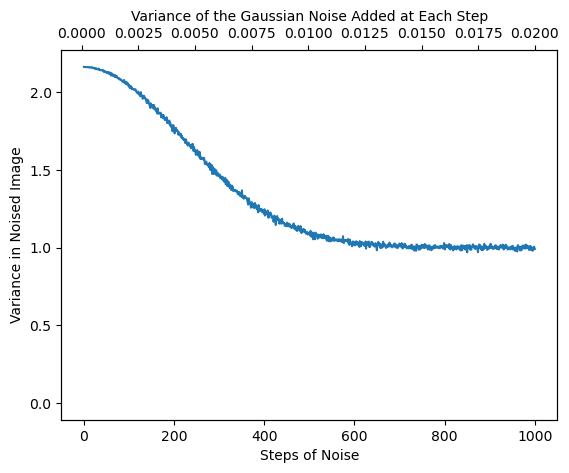

In [8]:
sample = train_gen[0][0][0]
print(sample.shape)
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    key = np.random.randint(0, 100000)
    noisy_im, noise = forward_noise(key, np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

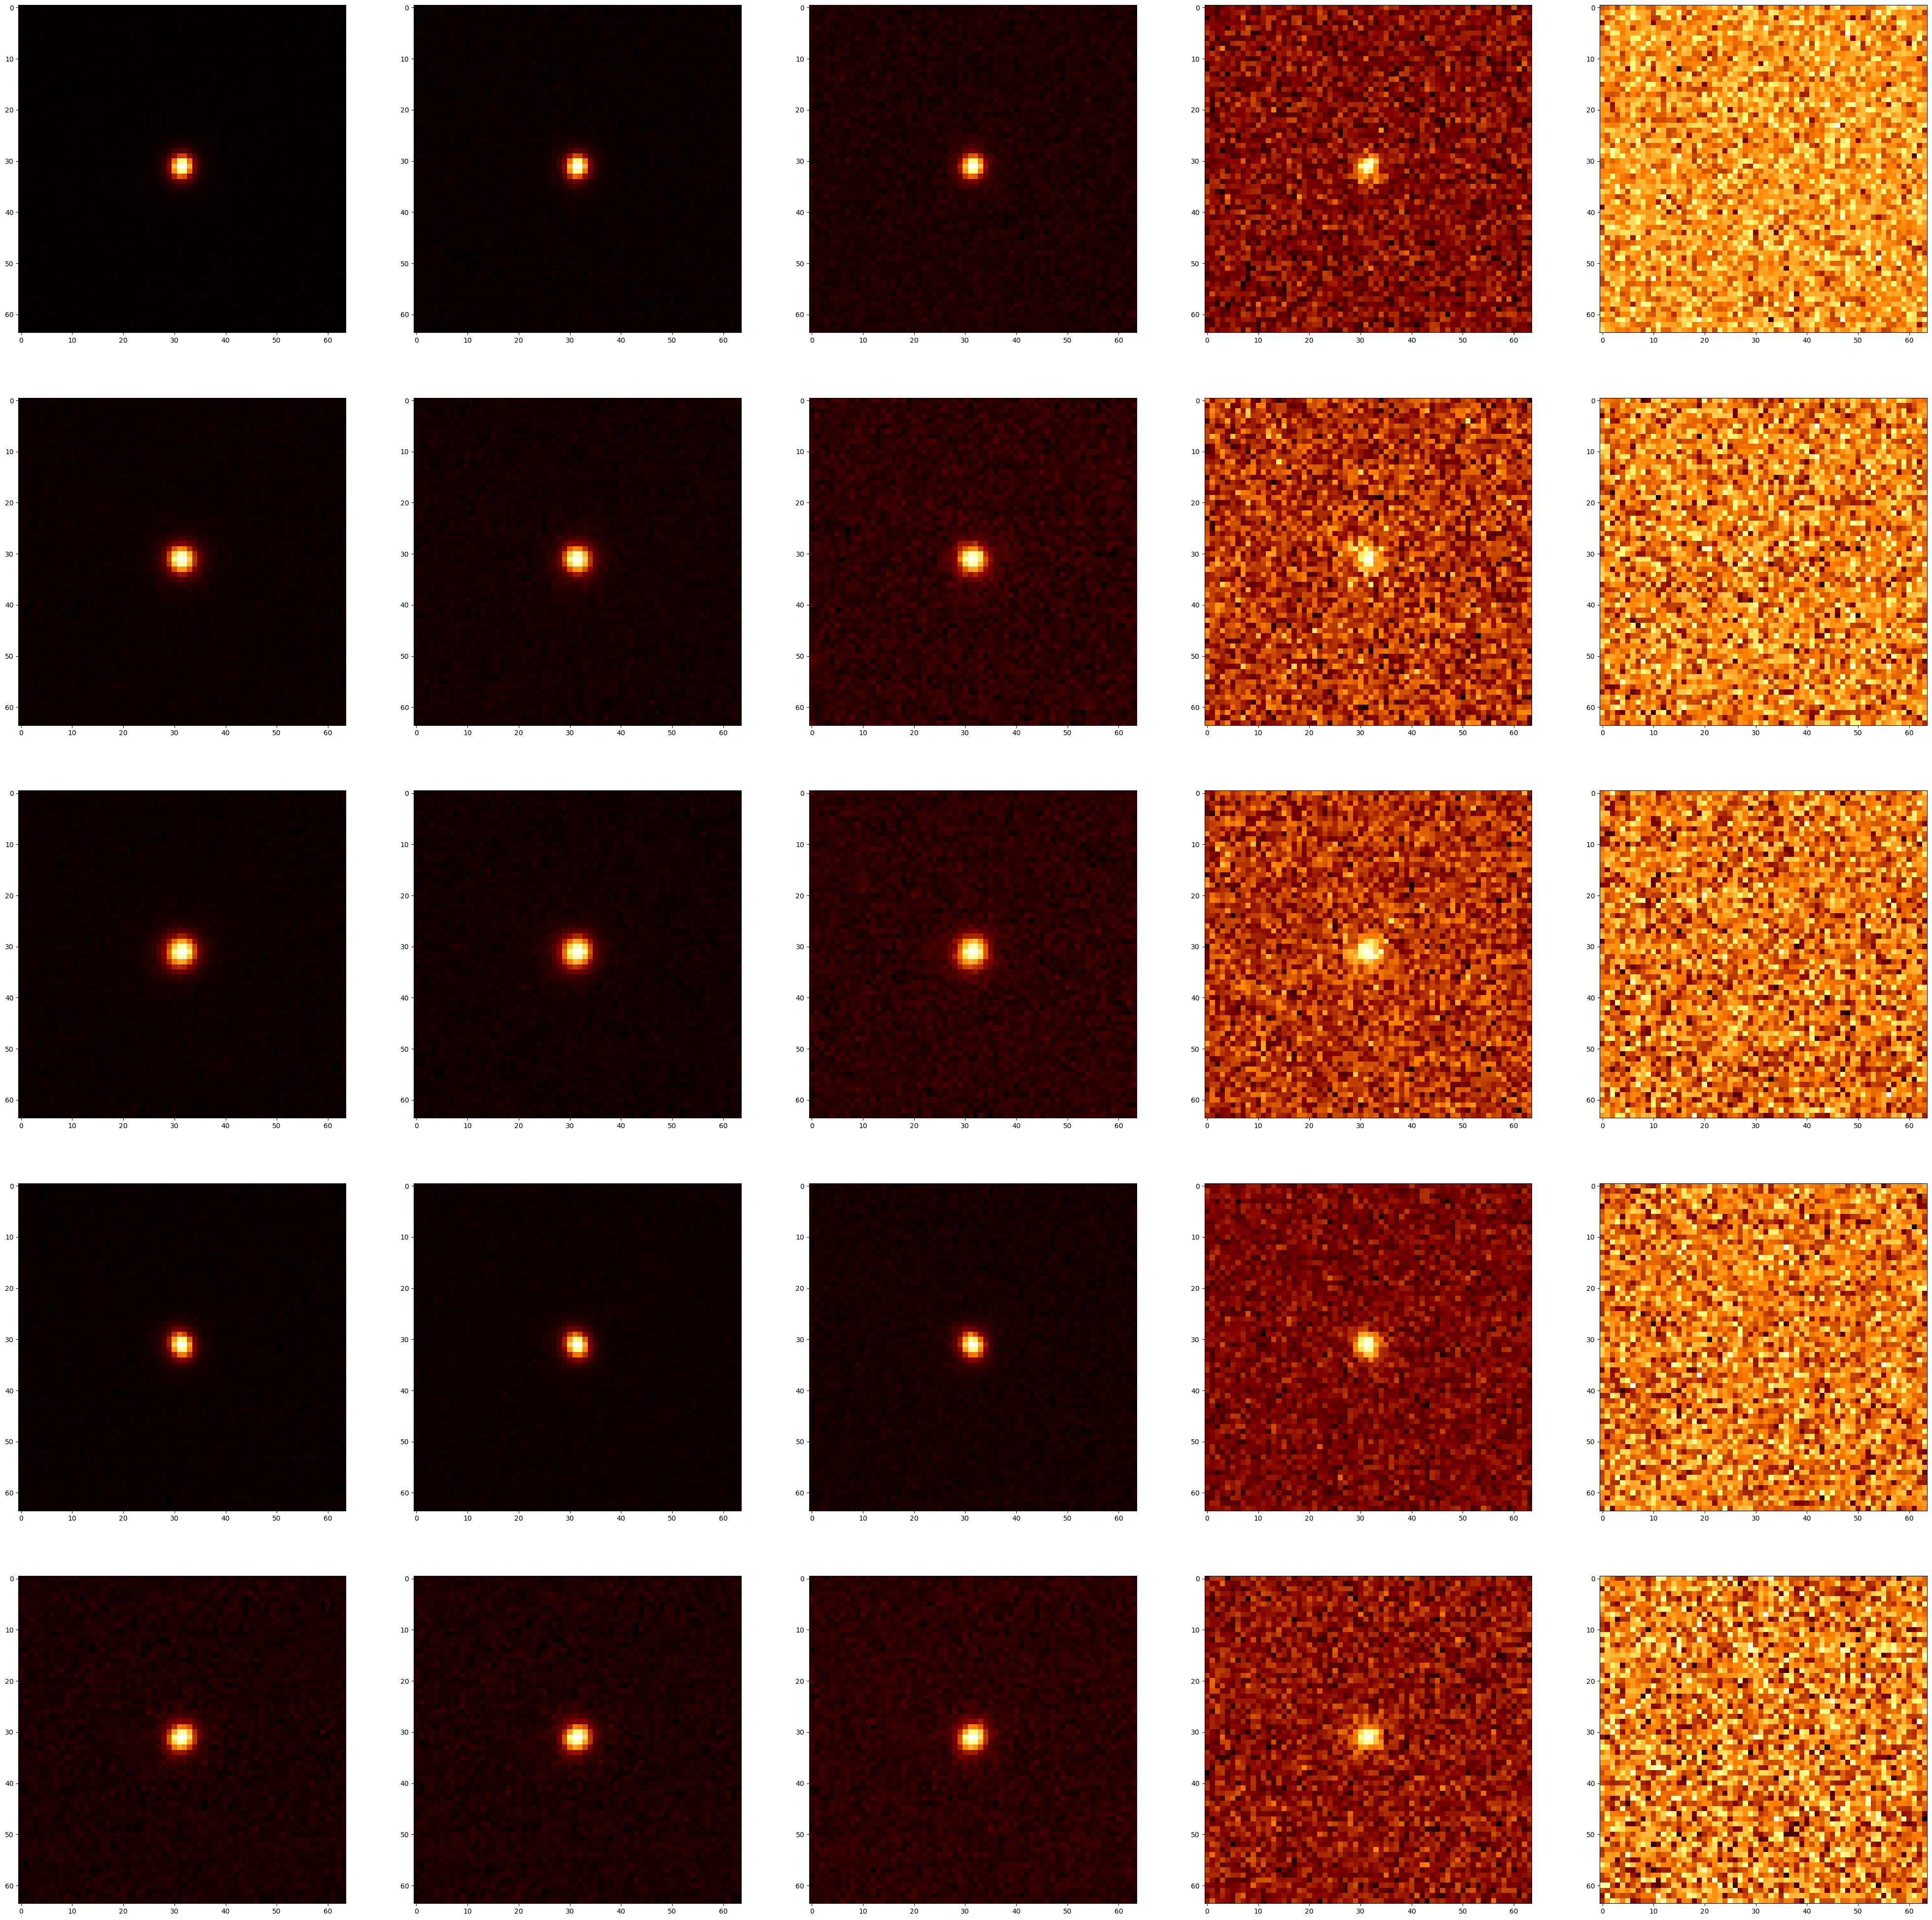

In [9]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 50, 150, 500, 999]):
    key = np.random.randint(0, 100000)
    noisy_im, noise = forward_noise(key, np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][4], cmap = 'afmhot')
    j += 1
    

plt.show()

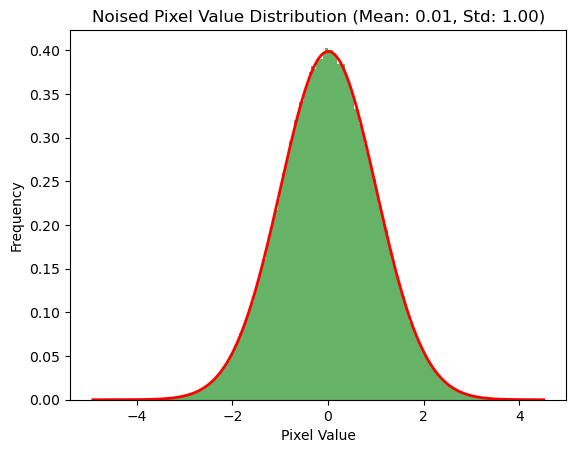

In [10]:
from scipy.stats import norm
from scipy.optimize import curve_fit

sample = train_gen[0][0]

key = np.random.randint(0, 100000)

noised_im, noise = forward_noise(key, sample, np.array([999, ]))
pixel_values = noised_im.ravel()
x_values = np.linspace(np.min(pixel_values), np.max(pixel_values), 1000)
# Calculate the normal distribution values for these x_values

bin_size = 0.05
bins = int((np.max(pixel_values) - np.min(pixel_values)) / bin_size)

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

histogram, bin_edges = np.histogram(pixel_values, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Fit the Gaussian distribution to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, histogram, p0=[0, 1, 1])
fitted_mean, fitted_std = popt[0], popt[2]

# Plot histogram
plt.hist(pixel_values, bins=bins, density=True, alpha=0.6, color='g')

# normal_distribution = len(pixel_values) * probability_in_bin * norm.pdf(x_values, 0, 1)
plt.plot(x_values, gaussian(x_values, *popt), color='r', linewidth=2)

plt.title(f'Noised Pixel Value Distribution (Mean: {fitted_mean:.2f}, Std: {fitted_std:.2f})')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
# plt.xlim(-5, 5)
plt.show()

In [11]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, dim, 1, 1]))
        self.b = tf.Variable(tf.zeros([1, dim, 1, 1]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=1, keepdims=True)
        mean = tf.reduce_mean(x, axis=1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x
    
class LayerNormChannelsFirst(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNormChannelsFirst, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [12]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05, axis=1)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last'),
            LayerNormChannelsFirst(dim)
        ])

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last')

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)
        
        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Conditioning(Layer):
    def __init__(self, res, num_channels=5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(num_channels * res * res),
            SiLU(),
            nn.Reshape((num_channels, res, res))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

In [13]:
class Unet_conditional(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=5,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True,
                 in_res=64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block_class = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                Conditioning(now_res),
                resnet_block_class(dim_in+1, dim_out, time_emb_dim=time_dim),
                resnet_block_class(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = Conditioning(now_res)
        self.mid_block1 = resnet_block_class(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block_class(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                Conditioning(now_res),
                resnet_block_class((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                resnet_block_class(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            resnet_block_class(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, redshift=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(redshift)
        x = tf.concat([x, cv], axis=1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = tf.concat([x, h.pop()], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=1)
        x = self.final_conv(x)
        return x

In [14]:
unet = Unet_conditional(
    in_res=64,
    channels=5
)

test_images = np.ones([1, 5, 64, 64])
test_timestamps = generate_timestamp(0, 1)
test_redshift = np.array([[1.0]])
k = unet(test_images, test_timestamps, test_redshift)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

2024-01-09 11:48:44.512236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-09 11:48:44.649970: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 11:48:44.895619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [15]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [16]:
def train_step(batch, condition):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [67]:
epochs = 10
save_frequency = 1

saved_weights_dir = "/data3/Billy/diffusion_saved_weights"
if not os.path.exists(saved_weights_dir):
    os.mkdir(saved_weights_dir)

# Load the latest saved weights, if any
latest_weights = sorted(glob.glob(f"{saved_weights_dir}/weights_epoch_*"))

if latest_weights:
    
    latest_epoch = int(latest_weights[-1].split('_')[-1].split('.')[0])  # Extract the epoch number from the filename
    unet.load_weights(latest_weights[-1].split('.')[0])
    print(f"Resuming from epoch {latest_epoch + 1}, loaded weights from {latest_weights[-1]}")
    
else:
    
    latest_epoch = -1  # Start from epoch 0
    print("Starting from epoch 0")

for e in range(latest_epoch + 1, epochs + latest_epoch + 1):
    bar = tf.keras.utils.Progbar(len(train_gen)-1)
    losses = []
    for i, batch in enumerate(iter(train_gen)):
        # run the training loop
        loss = train_step(batch[0], batch[1].reshape(-1, 1))
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    
    if e % save_frequency == 0:
        
        weight_file_path = f"{saved_weights_dir}/weights_epoch_{e}"
        unet.save_weights(weight_file_path)
        print(f"Saved weights to {weight_file_path}")

Resuming from epoch 17, loaded weights from /data3/Billy/diffusion_saved_weights/weights_epoch_16.index
6392/6392 [==============================] - 3233s 506ms/step - loss: 0.0528
Average loss for epoch 17/10: 0.05284572392702103
Saved weights to /data3/Billy/diffusion_saved_weights/weights_epoch_17
6392/6392 [==============================] - 3121s 488ms/step - loss: 0.0533
Average loss for epoch 18/10: 0.053266629576683044
Saved weights to /data3/Billy/diffusion_saved_weights/weights_epoch_18
6392/6392 [==============================] - 3125s 489ms/step - loss: 0.0533
Average loss for epoch 19/10: 0.05326548591256142
Saved weights to /data3/Billy/diffusion_saved_weights/weights_epoch_19
6392/6392 [==============================] - 3106s 486ms/step - loss: 0.0527
Average loss for epoch 20/10: 0.052739888429641724
Saved weights to /data3/Billy/diffusion_saved_weights/weights_epoch_20
6392/6392 [==============================] - 3104s 486ms/step - loss: 0.0529
Average loss for epoch 21

In [53]:
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [54]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [55]:
for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 5, 64, 64))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[0])
        img_list_r.append(np.squeeze(x, 0)[1])
        img_list_i.append(np.squeeze(x, 0)[2])
        img_list_z.append(np.squeeze(x, 0)[3])
        img_list_y.append(np.squeeze(x, 0)[4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


In [72]:
z = 0.1
seed = np.random.randint(0, 100000)
x = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g = []
img_list_r = []
img_list_i = []
img_list_z = []
img_list_y = []
img_list_g.append(np.squeeze(x, 0)[0])
img_list_r.append(np.squeeze(x, 0)[1])
img_list_i.append(np.squeeze(x, 0)[2])
img_list_z.append(np.squeeze(x, 0)[3])
img_list_y.append(np.squeeze(x, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, t, np.array([[z]]))
    x = ddpm(x, pred_noise, t)
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])

100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


In [73]:
z_2 = 3
seed = np.random.randint(0, 100000)
x_2 = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g_2 = []
img_list_r_2 = []
img_list_i_2 = []
img_list_z_2 = []
img_list_y_2 = []
img_list_g_2.append(np.squeeze(x_2, 0)[0])
img_list_r_2.append(np.squeeze(x_2, 0)[1])
img_list_i_2.append(np.squeeze(x_2, 0)[2])
img_list_z_2.append(np.squeeze(x_2, 0)[3])
img_list_y_2.append(np.squeeze(x_2, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t_2 = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise_2 = unet(x_2, t_2, np.array([[z_2]]))
    x_2 = ddpm(x_2, pred_noise_2, t_2)
    img_list_g_2.append(np.squeeze(x_2, 0)[0])
    img_list_r_2.append(np.squeeze(x_2, 0)[1])
    img_list_i_2.append(np.squeeze(x_2, 0)[2])
    img_list_z_2.append(np.squeeze(x_2, 0)[3])
    img_list_y_2.append(np.squeeze(x_2, 0)[4])

100%|██████████| 999/999 [02:44<00:00,  6.06it/s]


(0.0, 2.0)

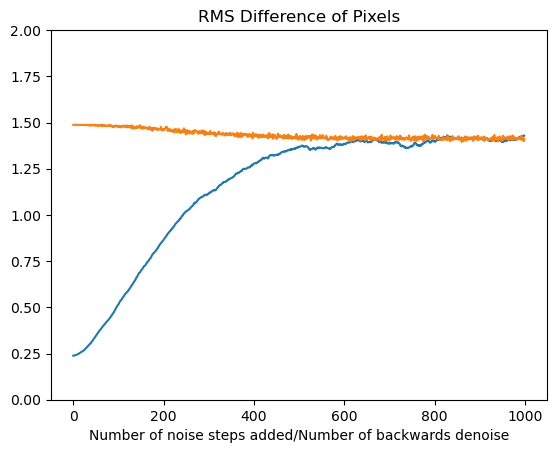

In [74]:
y_array = []
for i in range(999):
    rms = np.sqrt(np.mean((img_list_g[i].ravel() - img_list_g_2[i].ravel()) ** 2))
    y_array.insert(0, rms)
y_array_2 = []
sample = train_gen[0][0][0]
sample_2 = train_gen[0][0][1]
for i in range(999):
    key = np.random.randint(0, 100000)
    noisy_im_1, noise_1 = forward_noise(key, np.expand_dims(sample, 0), np.array([i, ]))
    key = np.random.randint(0, 100000)
    noisy_im_2, noise_2 = forward_noise(key, np.expand_dims(sample_2, 0), np.array([i, ]))
    rms = np.sqrt(np.mean((noisy_im_1.ravel() - noisy_im_2.ravel()) ** 2))
    y_array_2.append(rms)
x_array = range(999)
plt.plot(x_array, y_array, label = 'DDPM')
plt.plot(x_array, y_array_2, label = 'Original')
plt.title('RMS Difference of Pixels')
plt.xlabel('Number of noise steps added/Number of backwards denoise')
plt.ylim(0, 2)

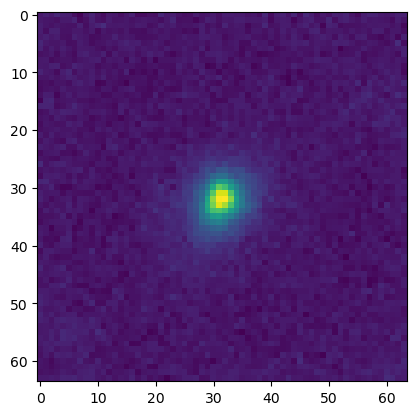

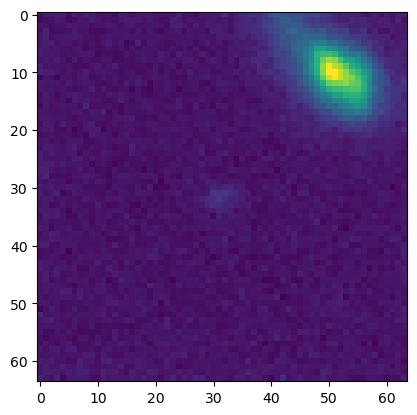

In [75]:
plt.imshow(img_list_g[999])
plt.show()
plt.imshow(img_list_g_2[999])
plt.show()

In [66]:
unet.summary()

Model: "unet_conditional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  10332     
                                                                 
 time embeddings (Sequential  (None, 256)              82432     
 )                                                               
                                                                 
 conditioning (Conditioning)  multiple                 40960     
                                                                 
 resnet_block (ResnetBlock)  multiple                  100288    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 107008    
 )                                                               
                                                                 
 residual (Residual)         multiple             

100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


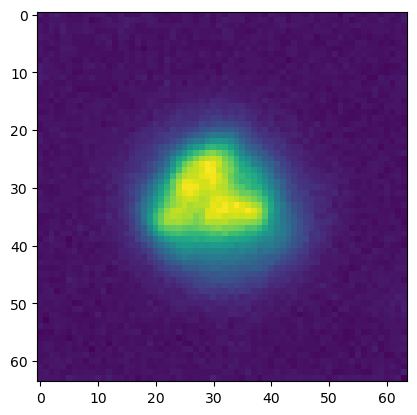

100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


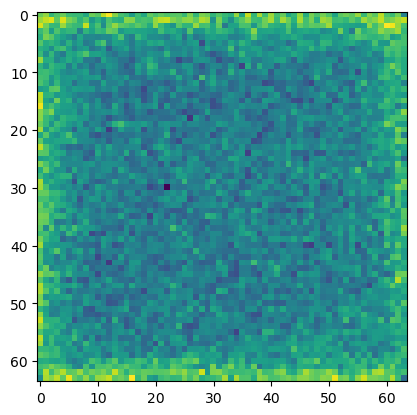

100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


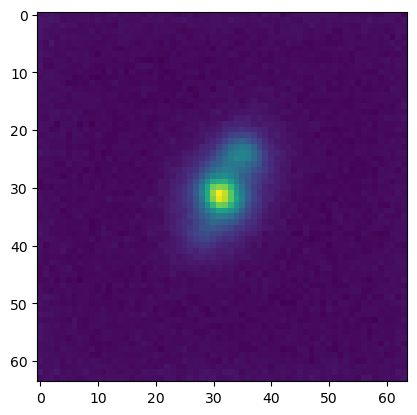

100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


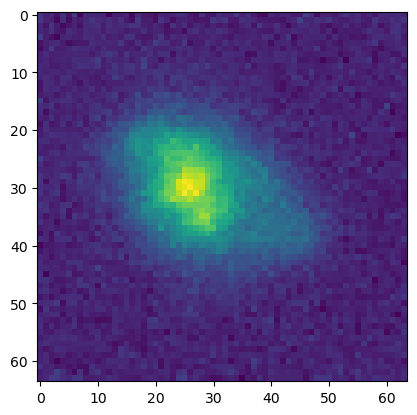

100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


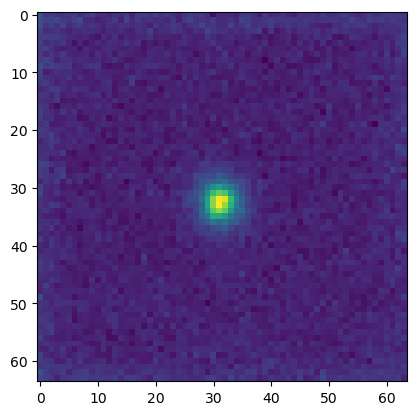

 61%|██████    | 610/999 [01:33<00:59,  6.49it/s]


KeyboardInterrupt: 

In [60]:
figure_count = 0
for number_of_gen in range(0, 10):
    figure_count += 1

    z = 0.1
    seed = np.random.randint(0, 100000)
    x = tf.random.normal((1, 5, 64, 64), seed=seed)

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])

    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[0])
        img_list_r.append(np.squeeze(x, 0)[1])
        img_list_i.append(np.squeeze(x, 0)[2])
        img_list_z.append(np.squeeze(x, 0)[3])
        img_list_y.append(np.squeeze(x, 0)[4])

    plt.figure(figure_count)
    plt.imshow(img_list_g[999])
    plt.show()

In [ ]:
# END